In [1]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)

import pandas as pd
import numpy as np


In [2]:
from sklearn.decomposition import PCA
# 데이터 가져오기
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(type(mnist.target[0])) # str로 되어있음
mnist.target = mnist.target.astype(np.uint8) # str을 숫자로 변경

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape) # 28*28 = 784


c:\Users\USER\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


<class 'str'>
(52500, 784)


## 차원 축소

### 랜덤 PCA와 점진적 PCA의 시간 복잡도

In [3]:
# 훈련 데이터 가져오기
# https://www.kaggle.com/hongfeiwang952700/my-mnist/version/1
# 로컬에 있는 데이터를 메모리에 전부 로드된 것 처럼 사용
filename = "./data/data/data/MNIST/raw/train-images.idx3-ubyte"
m, n = X_train.shape

# filename에 데이터를 메모리에 전부 로드한 것 처럼 사용 - 사용할 때 메모리에 로드
m, n = X_train.shape
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [4]:
# 훈련 데이터 가져오기
del X_mm # 변수 지옥 - 메모리가 부족하면 gc를 호출하는 것을 고려

In [5]:
# 데이터 가져오기
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
n_batches = 100
# 미니 배치의 크기 설정
batch_size = m // n_batches

from sklearn.decomposition import IncrementalPCA

inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

# 일반 PCA는 n_components를 설정할 때 0.0에서 1.0 사이로 설정하면 분산의 비율이 되고
# 2보다 큰 정수를 설정하면 주성분의 개수가 됨
# RandomPCA는 정수로만 설정 가능
# 주성분의 개수를 보고 가장 근사한 값을 찾아가는 방식이라서 주성분의 개수가 먼저 결정

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [10]:
# 주성분의 개수에 따른 시간 복잡도
import time
for n_components in(2,10,154):
    print("주성분 개수:", n_components)

    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("class name:", pca.__class__.__name__, "시간 :", (t2-t1))

주성분 개수: 2
class name: PCA 시간 : 3.819981098175049
class name: IncrementalPCA 시간 : 17.899473667144775
class name: PCA 시간 : 0.8049962520599365
주성분 개수: 10
class name: PCA 시간 : 3.808997869491577
class name: IncrementalPCA 시간 : 18.35775065422058
class name: PCA 시간 : 0.8579182624816895
주성분 개수: 154
class name: PCA 시간 : 3.9540483951568604
class name: IncrementalPCA 시간 : 21.021334648132324
class name: PCA 시간 : 2.2544689178466797


In [8]:
# 데이터의 개수에 따른 시간 복잡도
import time

for n_samples in (1000,10000,20000,30000,40000,50000):
    print("데이터의 개수:", n_samples)
    X = np.random.randn(n_samples,5)

    regular_pca = PCA(n_components=2, svd_solver="full")
    # 주성분의 개수에 영향을 많이 받음
    rnd_pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    # 데이터를 나누어서 훈련하므로 많은 양의 데이터나 온라인 학습에 적용
    inc_pca = IncrementalPCA(n_components=2, batch_size=500)

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("class name:", pca.__class__.__name__, "시간 :", (t2-t1))


데이터의 개수: 1000
class name: PCA 시간 : 3.726813793182373
class name: IncrementalPCA 시간 : 18.110512256622314
class name: PCA 시간 : 0.7929017543792725
데이터의 개수: 10000
class name: PCA 시간 : 3.6540448665618896
class name: IncrementalPCA 시간 : 18.044645071029663
class name: PCA 시간 : 0.7629299163818359
데이터의 개수: 20000
class name: PCA 시간 : 3.505084753036499
class name: IncrementalPCA 시간 : 18.11362886428833
class name: PCA 시간 : 0.7569591999053955
데이터의 개수: 30000
class name: PCA 시간 : 3.5308711528778076
class name: IncrementalPCA 시간 : 18.2362277507782
class name: PCA 시간 : 0.775982141494751
데이터의 개수: 40000
class name: PCA 시간 : 3.9680564403533936
class name: IncrementalPCA 시간 : 18.329620838165283
class name: PCA 시간 : 0.7711784839630127
데이터의 개수: 50000
class name: PCA 시간 : 3.72916316986084
class name: IncrementalPCA 시간 : 18.437231302261353
class name: PCA 시간 : 0.7690794467926025


In [11]:
# 데이터의 개수에 따른 시간 복잡도
import time

for n_features in (1000,2000,3000,4000,5000):
    print("피처의 개수:", n_features)
    X = np.random.randn(2000,n_features)

    regular_pca = PCA(n_components=2, svd_solver="full")
    # 주성분의 개수에 영향을 많이 받음
    rnd_pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    # 데이터를 나누어서 훈련하므로 많은 양의 데이터나 온라인 학습에 적용
    inc_pca = IncrementalPCA(n_components=2, batch_size=500)

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X)
        t2 = time.time()
        print("class name:", pca.__class__.__name__, "시간 :", (t2-t1))

피처의 개수: 1000
class name: PCA 시간 : 0.5460119247436523
class name: IncrementalPCA 시간 : 0.7019867897033691
class name: PCA 시간 : 0.05300140380859375
피처의 개수: 2000
class name: PCA 시간 : 2.8809142112731934
class name: IncrementalPCA 시간 : 1.341545820236206
class name: PCA 시간 : 0.09599804878234863
피처의 개수: 3000
class name: PCA 시간 : 5.989563465118408
class name: IncrementalPCA 시간 : 1.751589059829712
class name: PCA 시간 : 0.13599872589111328
피처의 개수: 4000
class name: PCA 시간 : 8.360223770141602
class name: IncrementalPCA 시간 : 2.2576653957366943
class name: PCA 시간 : 0.15199613571166992
피처의 개수: 5000
class name: PCA 시간 : 11.428938627243042
class name: IncrementalPCA 시간 : 3.245391845703125
class name: PCA 시간 : 0.19264602661132812


### 좋은 커널과 gamma 찾기

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA

from sklearn.datasets import make_swiss_roll
X,t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
# print(t) # 연속형이라 이대로는 로지스틱 사용 불가(로지스틱은 이진 분류)
# t는 연속형 데이터라서 분류에 사용할 수 없어서 bool 타입으로 변환
y = t > 6.9



clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03 , 0.032, 0.034, 0.037, 0.039, 0.041, 0.043, 0.046, 0.048,
       0.05 ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [18]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


### PCA를 이용한 잡음 제거

In [19]:
# 숫자 이미지 가져오기
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape # 8 * 8 이미지



(1797, 64)

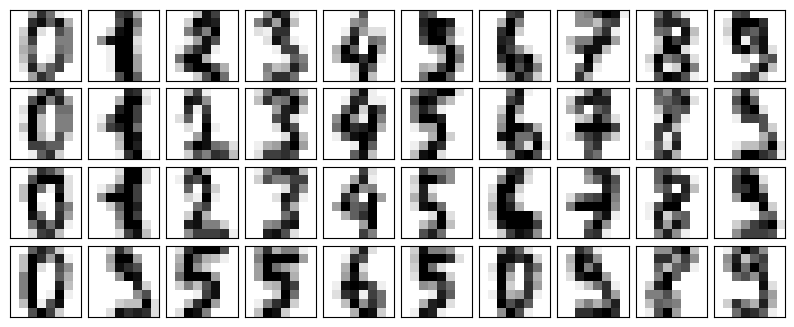

In [20]:
# 노이즈가 없는 입력 데이터 출력
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
# 원본 이미지 출력        
plot_digits(digits.data)



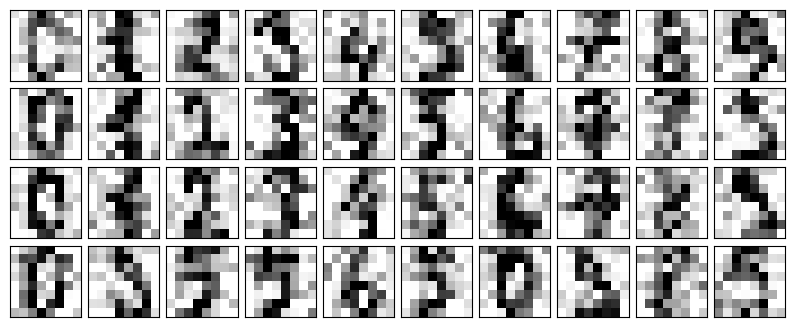

In [22]:
# 잡음 추가
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

26


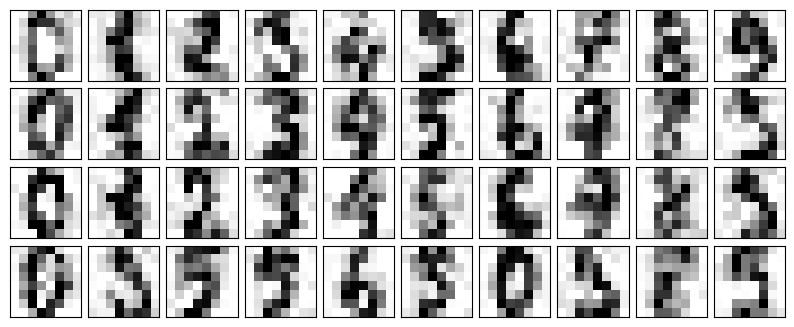

In [23]:
# PCA를 수행
pca = PCA(n_components=0.7).fit(noisy)
# 주성분 개수 확인
print(pca.n_components_)

# 잡음이 섞인 이미지를 주성분 분석 수행
components = pca.transform(noisy)
# 주성분 분석한 결과를 가지고 복원
filtered = pca.inverse_transform(components)
plot_digits(filtered)


## 텍스트 전처리

### 토큰화 - 문장이나 단어 단위로 분리하는 것

In [24]:
# nltk 패키지의 punkt 서브 패키지 설치
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# 문장 토큰화
text_sample = 'Hello World! Steve Jobs. 리처드 스톨만. 데니스 리치히.'
from nltk import sent_tokenize
sentences = sent_tokenize(text_sample)
print(sentences)


['Hello World!', 'Steve Jobs.', '리처드 스톨만.', '데니스 리치히.']


In [26]:
# 단어 토큰화
sentence = '손으로 코딩하고 뇌로 컴파일하며 눈으로 디버깅한다\n품질은 양보다 중요하다 한 번의 홈런이 두 번의 더블보다 낫다.'
from nltk import word_tokenize
words = word_tokenize(sentence)
print(words)


['손으로', '코딩하고', '뇌로', '컴파일하며', '눈으로', '디버깅한다', '품질은', '양보다', '중요하다', '한', '번의', '홈런이', '두', '번의', '더블보다', '낫다', '.']


### 스톱 워드 제거

In [30]:
import nltk
nltk.download('stopwords')

print("불용어 개수:", len(nltk.corpus.stopwords.words('english'))) # 179개
print("불용어 : ", nltk.corpus.stopwords.words('english')[:50])
stopwords = nltk.corpus.stopwords.words('english')
print(type(stopwords)) # list 형태
stopwords.append('jobs') # 불용어 리스트에 jobs 추가
print("불용어 개수:", len(stopwords)) # 하나(jobs) 늘어서 180개 됨

불용어 개수: 179
불용어 :  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']
<class 'list'>
불용어 개수: 180


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# 문장 토큰화
test_sample = 'I Love You Helo World! Steve Jobs. 리처드 스톨만. 데니스 리치히'
sentences = sent_tokenize(text_sample)
wordtokens = [word_tokenize(sentence) for sentence in sentences]
#
all_tokens=[]
for sentence in wordtokens:
    filtered_words=[]
    for word in sentence:
        # 영문의 경우는 대소문자의 경우를 잘 생각해야함
        lower_word = word.lower()
        if lower_word not in stopwords:
            filtered_words.append(word)
    all_tokens.append(filtered_words)
    
print(all_tokens)

[['Hello', 'World', '!'], ['Steve', '.'], ['리처드', '스톨만', '.'], ['데니스', '리치히', '.']]


### 단어의 어근 찾기

In [53]:
from nltk.stem import LancasterStemmer
stemmer = LancasterStemmer()

print(stemmer.stem('working'), stemmer.stem('work'), stemmer.stem('worked'))
print(stemmer.stem('amusing'), stemmer.stem('amuses'), stemmer.stem('amused'))
print(stemmer.stem('happy'), stemmer.stem('happiest'))
print(stemmer.stem('fancier'), stemmer.stem('fanciest'))

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
stemmer = WordNetLemmatizer()



print(stemmer.lemmatize('working','v'), stemmer.lemmatize('work','v'), stemmer.lemmatize('worked','v'))
print(stemmer.lemmatize('amusing','v'), stemmer.lemmatize('amuses','v'), stemmer.lemmatize('amused','v'))
print(stemmer.lemmatize('happy','a'), stemmer.lemmatize('happiest','a'))
print(stemmer.lemmatize('fancier','a'), stemmer.lemmatize('fanciest','a'))

work work work
amus amus amus
happy happiest
fant fanciest


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


work work work
amuse amuse amuse
happy happy
fancy fancy


### COO 방식의 희소 행렬 표현

In [57]:
data = np.array([3,1,2])

row_pos = np.array([0,0,1])
col_pos = np.array([0,2,1])

from scipy import sparse
sparse_coo = sparse.coo_matrix((data, (row_pos, col_pos)))
print(sparse_coo)


  (0, 0)	3
  (0, 2)	1
  (1, 1)	2


### CSR 형식을 이용한 희소 행렬

In [61]:
dense_matrix = np.array([[0,0,1,0,0,5],[1,4,0,3,2,5],
                         [0,6,0,6,0,0],[2,0,0,0,0,0],
                         [0,0,0,7,0,8],[1,0,0,0,0,0]])
data = np.array([1,5,1,4,3,2,5,6,6,2,7,8,1])
row_pos = np.array([0,0,1,1,1,1,1,2,2,3,4,4,5])
row_pos_index = np.array([0,2,7,9,10,12,13])
col_pos = np.array([2,5,0,1,3,4,5,1,3,0,3,5,0])

sparse_csr = sparse.csr_matrix((data, col_pos, row_pos_index))
print(sparse_csr.toarray())



[[0 0 1 0 0 5]
 [1 4 0 3 2 5]
 [0 6 0 6 0 0]
 [2 0 0 0 0 0]
 [0 0 0 7 0 8]
 [1 0 0 0 0 0]]


### pytagcloud를 이용한 wordcloud

['파이썬', '파이썬', '파이썬', '파이썬', '파이썬', '파이썬', '파이썬', '파이썬', '자바', '자바', '자바', '자바', '자바', '자바', '자바', '자바', '자바', '자바', 'C++', 'C++', 'C++', 'C++', 'C++', 'C++', 'C++', 'C++', 'C++', '코틀린', '코틀린', '코틀린', '코틀린', '코틀린', '코틀린', '코틀린', '코틀린', 'GO', 'GO', 'GO', 'GO', 'GO', 'GO', 'GO', 'GO', 'GO', '러스트', '러스트', '러스트', '러스트', '러스트', '러스트', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'C#', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'JavaScript', 'Scala', 'Scala', 'Scala', 'Scala', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL', 'SQL']
[('SQL', 12), ('자바', 10), ('C++', 9), ('GO', 9), ('JavaScript', 9), ('파이썬', 8), ('코틀린', 8), ('C#', 7), ('러스트', 6), ('Scala', 4)]
[{'color': (146, 201, 120), 'size': 68, 'tag': 'SQL'}, {'color': (18, 154, 197), 'size': 59, 'tag': '자바'}, {'color': (207, 53, 173), 'size': 54, 'tag': 'C++'}, {'color': (63, 49, 177), 'size': 54, 'tag': 'GO'}, {'color': (42, 127, 138), 'size': 54, 't

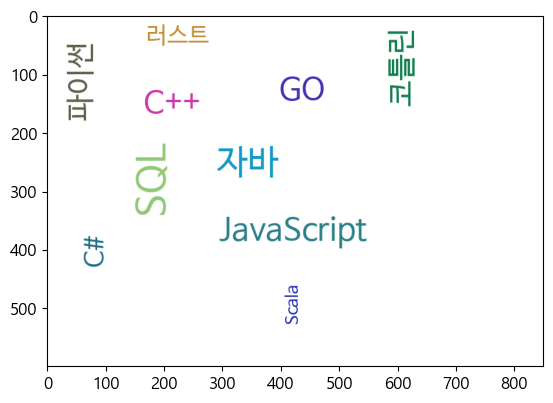

In [76]:
import pytagcloud
import collections
nouns = []

nouns.extend(['파이썬' for t in range(8)])
nouns.extend(['자바' for t in range(10)])
nouns.extend(['C++' for t in range(9)])
nouns.extend(['코틀린' for t in range(8)])
nouns.extend(['GO' for t in range(9)])
nouns.extend(['러스트' for t in range(6)])
nouns.extend(['C#' for t in range(7)])
nouns.extend(['JavaScript' for t in range(9)])
nouns.extend(['Scala' for t in range(4)])
nouns.extend(['SQL' for t in range(12)])

print(nouns)

# 데이터 개수 세기 - list 에서 데이터 개수 세기
count = collections.Counter(nouns)
"""
for x in count:
    print(x, count[x])
"""

# 가장 많이 등장한 것의 개수를 설정해서 가져오기
tag = count.most_common(10)
print(tag)

# 태그 목록 만들기
taglist = pytagcloud.make_tags(tag, maxsize=50)
print(taglist)

# 태그 클라우드 생성
pytagcloud.create_tag_image(taglist, 'wordcloud.png',
                            size=(900,600), fontname="Korean",
                            rectangular=False)

# 화면 출력
import matplotlib.pyplot
import matplotlib.image
img = matplotlib.image.imread('wordcloud.png')
imgplot=matplotlib.pyplot.imshow(img)
matplotlib.pyplot.show()


### wordcloud 패키지를 이용한 이미지 안에 워드클라우드 출력

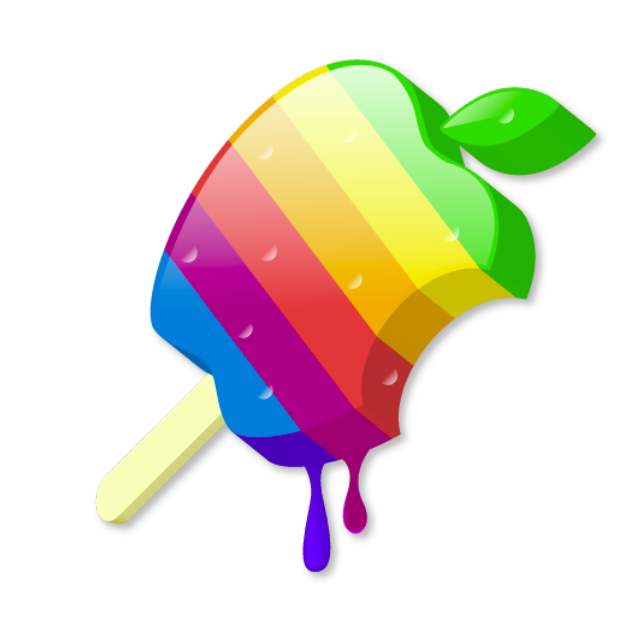

In [132]:
from PIL import Image

mask = np.array(Image.open('./data/data/data/appleBar.png'))
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()


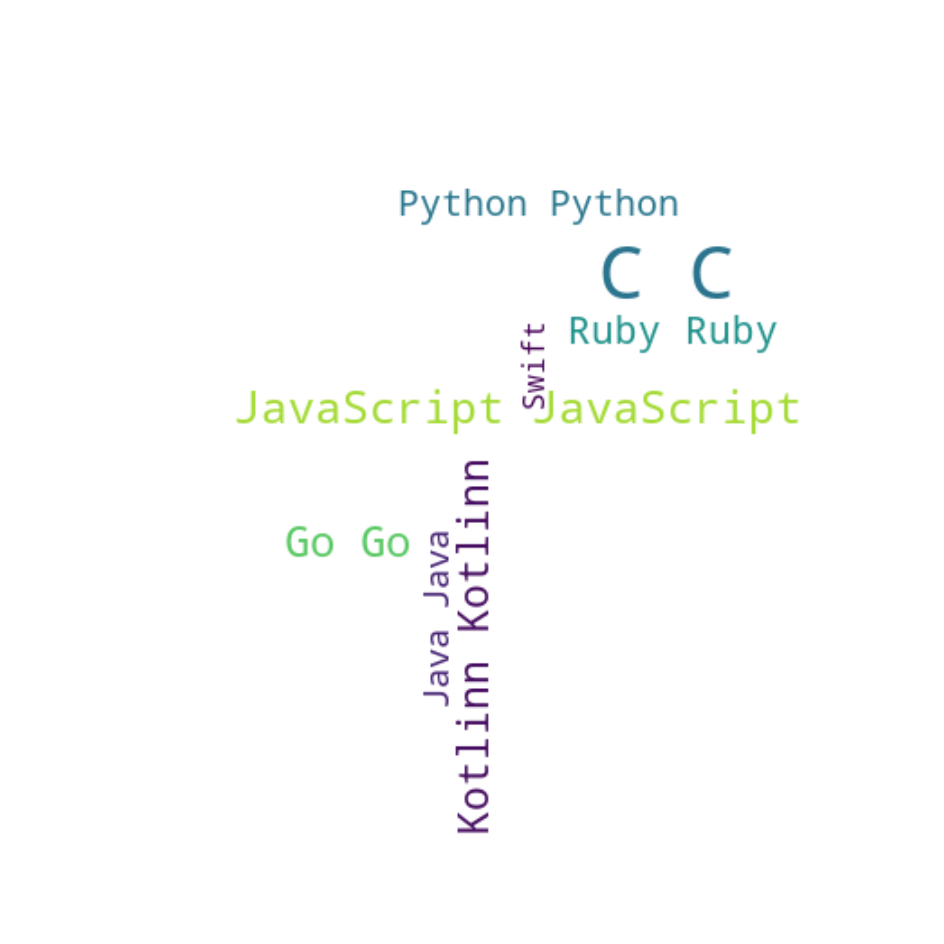

In [133]:
# 문자열 만들기
text = ''

for i in range(8):
    text = text + 'Python '
for i in range(11):
    text = text + 'C '
for i in range(7):
    text = text + 'Java '
for i in range(12):
    text = text + 'Go '
for i in range(11):
    text = text + 'Kotlinn '
for i in range(4):
    text = text + 'Swift '
for i in range(9):
    text = text + 'Ruby '
for i in range(7):
    text = text + 'C# '
for i in range(7):
    text = text + 'Solidity '
for i in range(13):
    text = text + 'JavaScript '


#print(text)

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.add('Solidity')

wordcloud = WordCloud(background_color='white', max_words=2000,
                      mask=mask, stopwords=stopwords)
wordcloud = wordcloud.generate(text)
#wordcloud.words_
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 동아일보에서 검색한 내용을 가지고 WordCloud 만들기

In [99]:
# Web의 정적 컨텐츠를 다운로드 받기 위한 패키지
import requests
from urllib.parse import quote

# HTML 파싱을 위한 패키지
from bs4 import BeautifulSoup

keyword = input('검색어 :')
target_URL = "https://www.donga.com/news/search?p=1" + "&query=" + quote(keyword) + "&check_news=91&more=1&sorting=1&search_date=1&v1=&v2="
source_code = requests.get(target_URL)
#print(source_code.text)

# HTML 파싱 객체 생성
bs = BeautifulSoup(source_code.text, 'html.parser')

# 파싱
tags = bs.select('div.cntPage > span') # 선택자는 중복이 가능하기 때문에 list로 리턴
count = int(tags[0].getText()[0:-1].replace(',',''))
print('기사 건수:', count)

기사 건수: 352813


In [105]:
# 실제 크롤링 할 기사 건수 입력받기
read_cnt = int(input("읽을 기사 건수:"))
if read_cnt > count :
    read_cnt = count
# 읽을 페이지 개수 생성
page_num = int(read_cnt / 15 + 0.95)
print(page_num)

3


In [120]:
output_file = open(keyword + '.txt', 'w', encoding='utf8')


for i in range(page_num):
    current_p = 1 + i * 15
    target_URL = "https://www.donga.com/news/search?p=" + str(current_p) + "&query=" + quote(keyword) + "&check_news=91&more=1&sorting=1&search_date=1&v1=&v2="
    #print(target_URL)
    
    # 각 검색 페이지의 데이터 읽어오기
    source_code = requests.get(target_URL)
    # 기사의 링크를 가져와야 함
    bs = BeautifulSoup(source_code.text, 'html.parser')

    links = bs.select('span.tit > a')
    #print(links)

    for link in links:
        title_link = link['href']
        #print(title_link) 링크 가져오기
        #상세 기사 링크에 접속해서 html 가져오기
        source_code = requests.get(title_link)
        bs=BeautifulSoup(source_code.text, 'html.parser')
        articles = bs.select('#article_txt')
        if articles != None :
            for article in articles:
                #print(article.getText())
                string_item = str(article.find_all(text=True))
                output_file.write(string_item)
output_file.close()


In [121]:
# 한글 형태소 분석기를 활용해서 한글 텍스트를 추출
from konlpy.tag import Twitter
open_text_file = open(keyword + ".txt" , "r", encoding='utf8')
text = open_text_file.read()
spliter = Twitter()
nouns = spliter.nouns(text)
open_text_file.close()
print(nouns)

c:\Users\USER\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['북한', '지령', '미군', '철수', '투쟁', '등', '주도', '유죄', '판결', '한충', '목', '한국', '진보연대', '공동', '대표', '민주당', '출신', '무소속', '윤미향', '의원', '한국', '간토', '학살', '주기', '추도', '사업', '추진', '위원회', '구성', '추진', '위로', '국회의원', '추도', '행사', '참여', '요청', '고', '가운데', '한일', '정보', '당국', '추진', '위', '대표', '한충', '목', '한국', '진보연대', '대표', '활동', '살피', '것', '파악', '윤', '의원', '앞서', '우리', '정부', '후원', '재일', '대한민국', '민단', '민단', '이', '개최', '간토', '대지진', '한국인', '희생', '추도', '대신', '친북', '단체', '재일', '조선인', '연합', '회', '총련', '추도', '행사', '참석', '논란', '빚', '한일', '당국', '양국', '정부', '대표', '총련', '및', '북한', '당국', '관계', '점', '주목', '북한', '측', '접선', '여부', '및', '소통', '내용', '등', '보고', '대표', '일본', '도쿄', '요코', '아미', '초', '공원', '총련', '주최', '개최', '간토', '대지진', '조선인', '학살', '도쿄', '동포', '추도', '모임', '공개', '이름', '등장', '한국', '인사', '대표', '날', '추진', '위', '명의', '련', '인사', '북한', '표기', '일본', '정부', '기만', '역사', '정의', '바로', '아시아', '공동', '번영', '향', '제목', '인사', '문', '총련', '대표', '중국', '북한', '개성', '북한', '공작원', '지령', '국내', '맥아더', '동상', '철거', '투쟁', '미군', '철수', '투쟁', '등', '혐의'

전체 단어 개수 : 10001
전체 단어 개수 - 중복 제거 :  2517
<FreqDist with 2517 samples and 10001 outcomes>


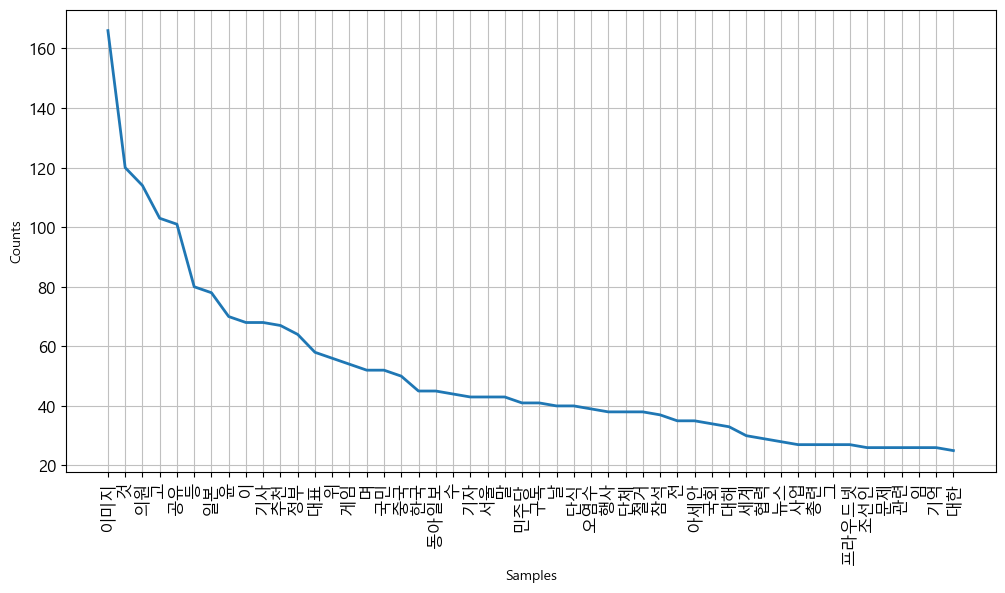

In [123]:
# 단어 개수와 등장 횟수 확인
import nltk
ko = nltk.Text(nouns, name=keyword)
print('전체 단어 개수 :', len(ko.tokens))
print('전체 단어 개수 - 중복 제거 : ', len(set(ko.tokens)))
print(ko.vocab())
plt.figure(figsize=(12,6))
ko.plot(50)
plt.show()

In [126]:
# 불용어 제거
stop_words = ['이미지','것','고','공유','등']
ko_1 = [each_word for each_word in ko if each_word not in stop_words]
ko_2 = [each_word for each_word in ko_1 if ko_1 if len(each_word) > 1]
print(ko_2)

['북한', '지령', '미군', '철수', '투쟁', '주도', '유죄', '판결', '한충', '한국', '진보연대', '공동', '대표', '민주당', '출신', '무소속', '윤미향', '의원', '한국', '간토', '학살', '주기', '추도', '사업', '추진', '위원회', '구성', '추진', '위로', '국회의원', '추도', '행사', '참여', '요청', '가운데', '한일', '정보', '당국', '추진', '대표', '한충', '한국', '진보연대', '대표', '활동', '살피', '파악', '의원', '앞서', '우리', '정부', '후원', '재일', '대한민국', '민단', '민단', '개최', '간토', '대지진', '한국인', '희생', '추도', '대신', '친북', '단체', '재일', '조선인', '연합', '총련', '추도', '행사', '참석', '논란', '한일', '당국', '양국', '정부', '대표', '총련', '북한', '당국', '관계', '주목', '북한', '접선', '여부', '소통', '내용', '보고', '대표', '일본', '도쿄', '요코', '아미', '공원', '총련', '주최', '개최', '간토', '대지진', '조선인', '학살', '도쿄', '동포', '추도', '모임', '공개', '이름', '등장', '한국', '인사', '대표', '추진', '명의', '인사', '북한', '표기', '일본', '정부', '기만', '역사', '정의', '바로', '아시아', '공동', '번영', '제목', '인사', '총련', '대표', '중국', '북한', '개성', '북한', '공작원', '지령', '국내', '맥아더', '동상', '철거', '투쟁', '미군', '철수', '투쟁', '혐의', '구속기소', '대법원', '징역', '개월', '집행유예', '선고', '원심', '확정', '대표', '부인', '시민', '모임', '대표', '의원', '활동', '한국', '정신대', 

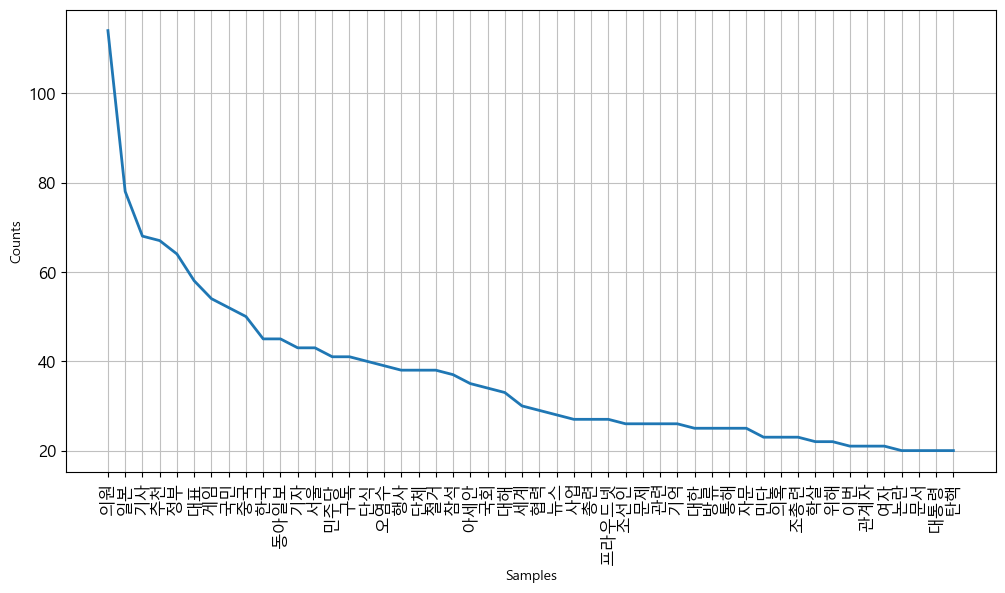

In [127]:
ko = nltk.Text(ko_2, name=keyword)
plt.figure(figsize=(12,6))
ko.plot(50)
plt.show()

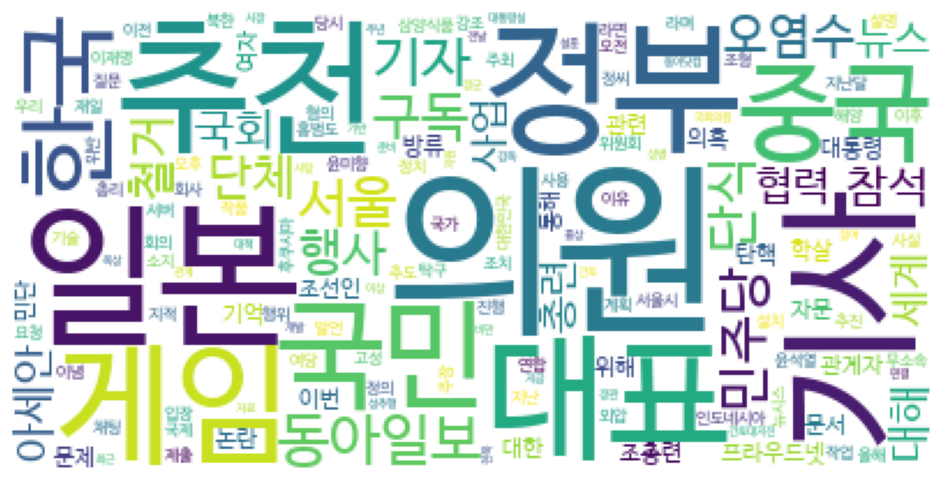

In [129]:
data = ko.vocab().most_common(150)

wordcloud = WordCloud(relative_scaling=0.5, font_path='./data/data/data/NanumBarunGothic.ttf',
                      background_color='white').generate_from_frequencies(dict(data))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

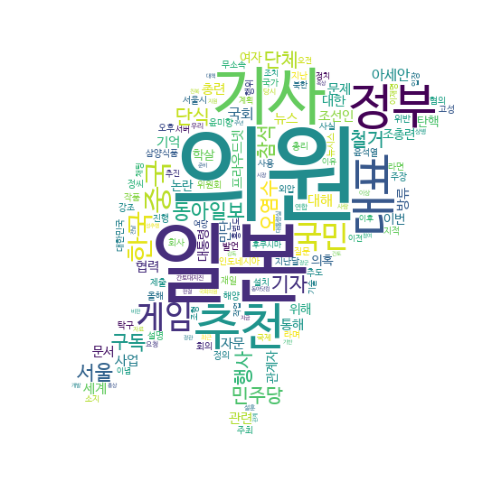

In [131]:
data = ko.vocab().most_common(150)
mask = np.array(Image.open('./data/data/data/appleBar.png'))
wordcloud = WordCloud(relative_scaling=0.5, font_path='./data/data/data/NanumBarunGothic.ttf',
                      background_color='white', mask=mask).generate_from_frequencies(dict(data))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 뉴스 그룹 분류

In [134]:
# 데이터 가져오기
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', random_state=42)
print(news_data.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [135]:
# 분포 확인
print(pd.Series(news_data.target).value_counts().sort_index())


0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
dtype: int64


In [138]:
# 클래스 이름확인
print(news_data.target_names)
# 데이터 확인
print(news_data.data[0])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>
Subject: Pens fans reactions
Organization: Post Office, Carnegie Mellon, Pittsburgh, PA
Lines: 12
NNTP-Posting-Host: po4.andrew.cmu.edu



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season st